<a href="https://colab.research.google.com/github/masdesouza/FDIA-PdM/blob/master/notebooks/regression_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import modules

In [2]:
# Regression models: How many more cycles an in-service engine will last before it fails?
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.activations import tanh, linear
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

#2. Configuration

In [3]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '/content/drive/MyDrive/PFC/FDIA-PdM/Trained models/GRU/regression_model_GRU.h5'

##2.1 Import dataset

In [4]:
import os
import pickle
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive")

Mounted at /content/drive


# 3. Data Ingestion

In [5]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/CMAPSSData/train_FD002.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/CMAPSSData/test_FD002.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Datasets/CMAPSSData/RUL_FD002.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


#4. Data Preprocessing

## 4.1 Train

In [6]:
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

#train_df.to_csv('../../Dataset/PredictiveTraining.csv', encoding='utf-8',index = None)

## 4.2 Test


In [7]:
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceTest.csv', encoding='utf-8',index = None)

# pick a large window size of 50 cycles
sequence_length = 80

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.238019  0.297150  ...  1.0  0.625514  0.633951    0.000000
1   1      2  0.476162  0.831354  ...  1.0  0.483882  0.500205    0.002653
2   1      3  0.833282  0.997625  ...  1.0  0.164609  0.165078    0.005305
3   1      4  0.999967  0.998812  ...  1.0  0.005830  0.023186    0.007958
4   1      5  0.595089  0.737886  ...  0.0  0.141632  0.145822    0.010610

[5 rows x 27 columns]
69
(32959, 80, 25)


(32959, 1)

#5. Modeling

In [8]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(GRU(input_shape=(sequence_length, nb_features),units=100, activation='tanh', return_sequences=True))
model.add(Dropout(0.15))  # Dropout overfitting

# model.add(GRU(layers[2],activation='tanh', return_sequences=True))
# model.add(Dropout(0.2))  # Dropout overfitting

model.add(GRU(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.15))  # Dropout overfitting

model.add(GRU(100, activation='tanh', return_sequences=True))
model.add(Dropout(0.15))  # Dropout overfitting

#model.add(GRU(64, activation='tanh', return_sequences=True))
#model.add(Dropout(0.15))  # Dropout overfitting

model.add(GRU(100, activation='tanh', return_sequences=False))
model.add(Dropout(0.15))  # Dropout overfitting


model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=[rmse,r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tensorflow.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())


# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nRMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('/content/drive/MyDrive/PFC/FDIA-PdM/Output/submit_train_GRU.csv', index = None)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 80, 100)           38100     
_________________________________________________________________
dropout (Dropout)            (None, 80, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 80, 100)           60600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 80, 100)           60600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               6

#6. EVALUATE ON TEST DATA


seq_array_test_last
(188, 80, 25)
(188, 1)
label_array_test_last
[[ 18.]
 [106.]
 [110.]
 [ 15.]
 [  6.]
 [ 90.]
 [ 11.]
 [ 79.]
 [  6.]
 [ 30.]
 [ 11.]
 [ 37.]
 [ 67.]
 [ 68.]
 [ 22.]
 [ 54.]
 [ 97.]
 [ 10.]
 [ 77.]
 [ 88.]
 [ 83.]
 [ 78.]
 [ 75.]
 [ 11.]
 [ 53.]
 [100.]
 [ 55.]
 [ 48.]
 [ 37.]
 [ 44.]
 [ 27.]
 [ 18.]
 [  6.]
 [ 15.]
 [112.]
 [131.]
 [ 13.]
 [ 13.]
 [ 53.]
 [ 52.]
 [103.]
 [ 26.]
 [ 73.]
 [ 39.]
 [ 39.]
 [ 14.]
 [ 11.]
 [ 86.]
 [ 56.]
 [115.]
 [ 17.]
 [104.]
 [ 78.]
 [ 86.]
 [ 98.]
 [ 36.]
 [ 52.]
 [ 91.]
 [ 15.]
 [ 74.]
 [ 17.]
 [ 47.]
 [194.]
 [ 21.]
 [ 79.]
 [  8.]
 [  9.]
 [ 73.]
 [ 97.]
 [ 49.]
 [ 31.]
 [ 97.]
 [  9.]
 [ 14.]
 [  8.]
 [  8.]
 [106.]
 [ 61.]
 [168.]
 [ 35.]
 [ 80.]
 [  9.]
 [ 50.]
 [ 78.]
 [ 91.]
 [  7.]
 [150.]
 [106.]
 [ 15.]
 [  7.]
 [124.]
 [ 82.]
 [108.]
 [ 79.]
 [121.]
 [ 39.]
 [ 38.]
 [  9.]
 [167.]
 [ 88.]
 [  7.]
 [ 51.]
 [ 55.]
 [ 47.]
 [ 81.]
 [ 43.]
 [ 98.]
 [ 10.]
 [ 11.]
 [ 34.]
 [115.]
 [ 59.]
 [ 99.]
 [171.]
 [ 15.]
 [  9.]
 [ 42.]

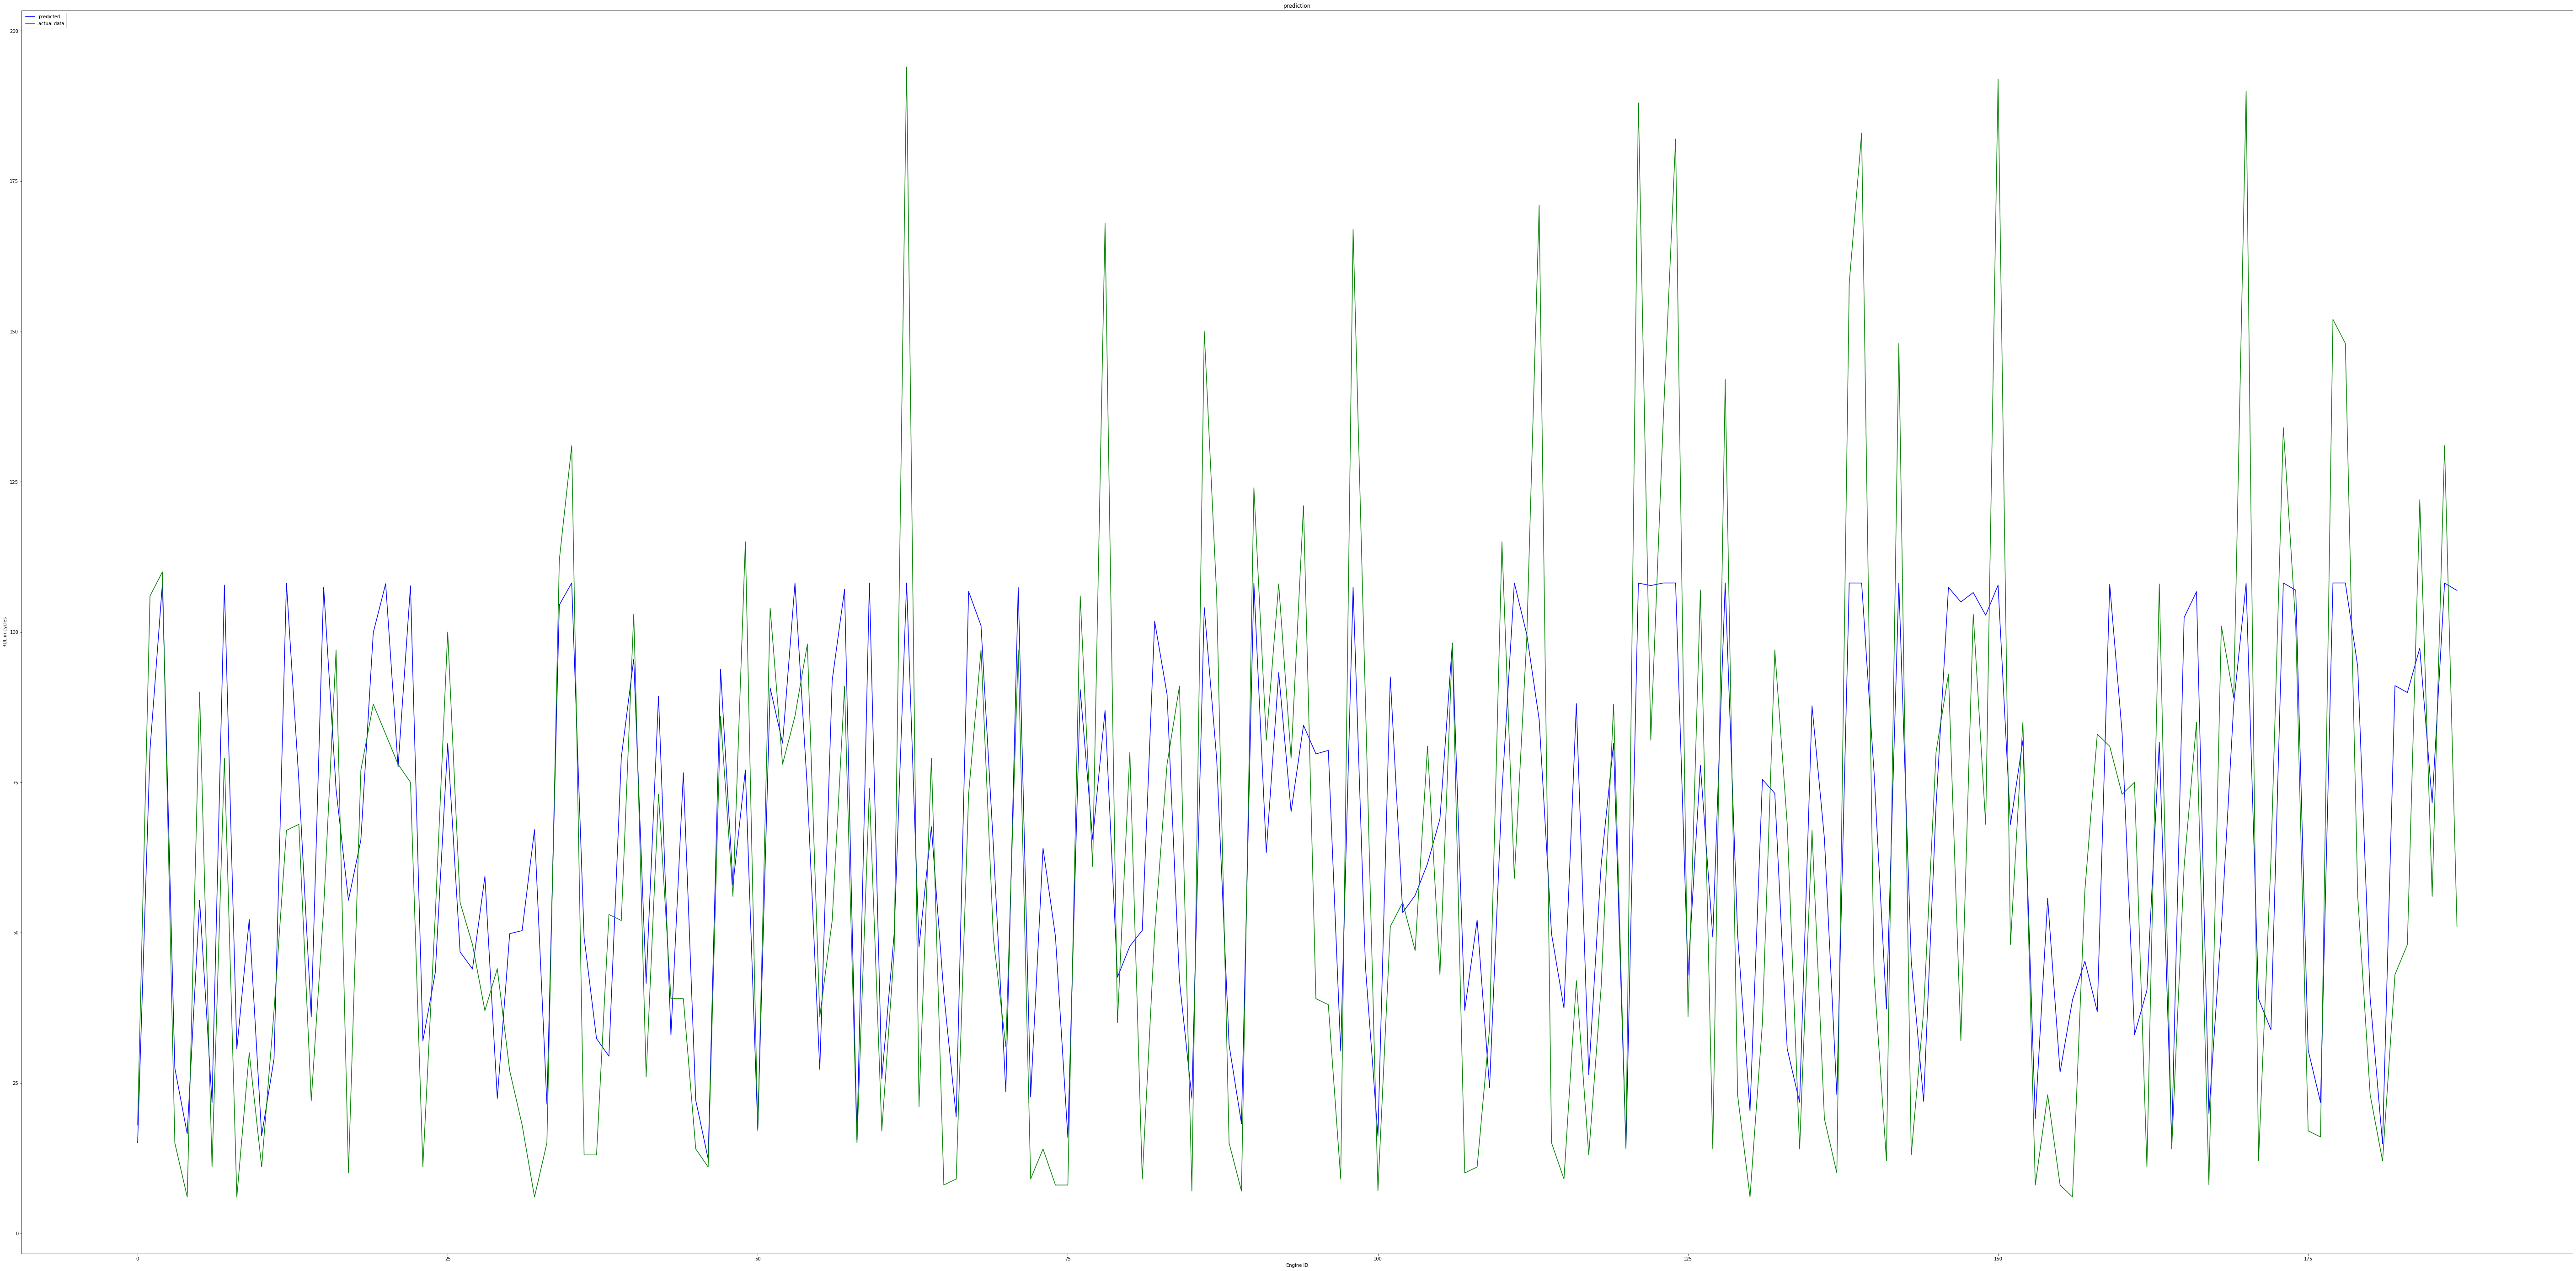

In [9]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path, custom_objects={'r2_keras': r2_keras, 'rmse': rmse})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nRMSE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last
    print("Prediction")
    print(y_pred_test);
    print("Truth")
    print(y_true_test);

    #y_pred_test.to_csv('../../Output/Regression_Pred_test.csv', index=None)
    #y_true_test.to_csv('../../Output/Regression_True_test.csv', index=None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(100, 50))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('RUL in cycles')
    plt.xlabel('Engine ID')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("/content/drive/MyDrive/PFC/FDIA-PdM/Output/model_regression_verify_GRU.png")